# Forecasting Hurricane Tracks using Satellite Data Accessed from AWS

When I originally took a crack at forecasting hurricanes with Tensorflow back in 2019, I used Reanalysis data I had to download via ftp and satelitte imagery I webscraped from NASA. It worked well enough, except the reanlysis II data had one major flaw; it was not a perfect mirror for what could be acquired live via NOAA's various other products. Since that time, there's been a major effort by NOAA and other government agencies via the [NOAA Big Data Program](https://www.noaa.gov/organization/information-technology/big-data-program) to move many of both NOAA and NASA's data products to the cloud, both on Amazon AWS and Google Cloud. Many of these datasets span back 3-4 years, and include hourly observations, instead of the 6 hour increments from the reanalysis datasets previously used. Most importantly, however, new observations are added live, in the same format and in the same location, so using a model developed with these datasets could be adapted to live forecasting with minimal effort.

The downside here is that the historic data would ideally cover a longer time period. Our historic track data is every 3 hours, so even if we augment this via interpolation and assume that our hourly interpolated data is accurate enough to use for training, we're still limited in that there were a finite number of storms during this period and there may be several regions of the world that commonly see storms pass through which didn't see one during this period, and therefore our model may not properly learn storm behavoirs in those regions.

Ultimately, down the road we'll probably  want to create a composite training set that includes the previous Reanlysis II data as well, but I wanted to first present a comprehensive methodology for accessing these new datasets, and using them to train Tensorflow models. Adding in the older data for a longer training period is likely to be the next step, and will likely require that we shift which AWS / GCP datasets we draw from to match like with like, but the code to access them should work the same. 

To begin, I'll start with the Geospatial Satellite data from AWS (GOES16 and 17). The Google data requires a few extra steps to use properly as you need to sign up for a Google Earth Engine account. Google Earth Engine offers a lot of nice features, from the ability to export data into tf.data datasets to being able to use it to directly train hosted models directly on GCP and create high resolution maps including data from other sources fairly easily, but the drawback is that most of the examples are in javascript and assume users will use the javascript browser IDE to pull data. That means some going back and forth from python to js. So, I'm going to start with the AWS data for now, as it allows me to keep everything in a single Jupyter notebook that doesn't rely on premium GCP services to run and is fairly easy follow.

Anyway, Let's begin!

As a starting point, check out this notebook: [Visualize GOES-16 Data from S3](https://github.com/HamedAlemo/visualize-goes16/blob/master/visualize_GOES16_from_AWS.ipynb)

I'll be using some of the code here to get things rolling.

In [1]:
from tensorflow.keras.layers import Input, Dense, concatenate, AlphaDropout,Dropout,BatchNormalization,Conv2D,DenseFeatures,MaxPooling2D,Flatten
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import feature_column as fc
from tensorflow.compat.v1.losses import mean_pairwise_squared_error

# from math import floor
import tensorflow as tf
# from get_data_v4_generalized import open_pkl_multi
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import Callback,EarlyStopping,CSVLogger,ReduceLROnPlateau
# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
import xarray as xr
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
from tqdm import tqdm
import gc
import os
from IPython.display import Image
import cv2
from multiprocessing import Pool
os.environ['PROJ_LIB'] = r'c:\Users\kylea\AppData\Local\conda\conda\envs\hurricanes\Library\share'
from disk_gen import generate_composite_mp
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import numpy as np
from math import pi



# Full Disks
This is going to work the same way as notebook 1, except instead of generating storm centered images, we'll just save the full disk images for every timestamp in our track data, and then we'll feed these into our latest model via a 4th branch with an identical structure to our storm centered image input branch. But first, let's see if we can do anything cool by combining three bands together to form an rbg image that contains more data than any single image.

Also, we'll be adding in the previous position at each timestep. Hopefully the combination of these additional inputs will help our model break the pattern of consistently forecasting along the vector.

In [3]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'#'ABI-L2-DMWF'#'ABI-L2-CMIPF'#'ABI-L1b-RadF'#ABI-L2-ACHTF#'ABI-L2-ACTPF'#
year = 2017
day_of_year = 59
hour = 0
band = 14

In [4]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [5]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key
            

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [6]:
print(f'{day_of_year:02.0f}')

59


In [7]:
print(f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M*C{band:02.0f}')
#OR_ABI-L1b-RadF-M6C16_G16

ABI-L1b-RadF/2017/059/00/OR_ABI-L1b-RadF-M*C14


In [8]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                  )
# keys = get_s3_keys(bucket_name,
#                    s3_client)
#                    prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
#                   )
all_keys= [key for key in keys]
key = all_keys[0] # selecting the first measurement taken within the hour

In [9]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

In [10]:
%%time
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)

Wall time: 7 ms


Wall time: 581 ms


(-0.5, 5423.5, 5423.5, -0.5)

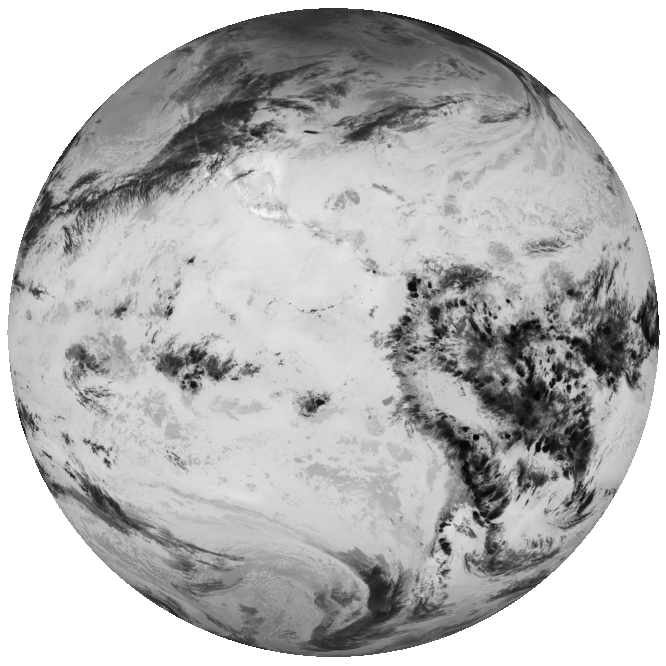

In [11]:
%%time
fig = plt.figure(figsize=(12, 12))
rad=nc4_ds.variables['Rad'][:]
plt.imshow(rad, cmap='gray')
plt.axis('off')
# plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w',bbox_inches='tight',pad_inches=0,transparent=True)

# Make this into a function
To combine multiple bands / channels together, we'll need a function that lets us grab one disk at a time for a given timestamp / band combination.

In [12]:
def gen_disk(year=2017,day_of_year=59,hour=0,band=12):
    gc.collect()
    
    #we use the follow try: except: because apparently at some point during this period, the prefix changes from M3C to M6C. If one fails, try the other.
    try:
        keys = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                      )
        all_keys= [key for key in keys]
        key = all_keys[0]
    except:
        keys = get_s3_keys(bucket_name,
                       s3_client,
                       prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}'
                      )
        all_keys= [key for key in keys]
        key = all_keys[0]        
#     key=next(keys)#just get first key, for first image after the hour.
    resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')
    
    file_name = key.split('/')[-1].split('.')[0]
    g16nc = netCDF4.Dataset(file_name, memory = resp.content)
    rad=g16nc.variables['Rad'][:]
    rad_max=rad.max()
    rad_min=rad.min()
    rad_range=rad_max-rad_min
    rad=rad-rad_min
    rad=rad/rad_range
    rad=255*rad
    rad=rad.astype(int)
    return rad.filled(128)

In [13]:
%%time
r=gen_disk(band=8)

Wall time: 3.04 s


In [14]:
g=gen_disk(band=12)

In [15]:
b=gen_disk(band=16)

### Combine 3 channels to form pseudo color image

In [16]:
combined=np.dstack([r,g,b])

(-0.5, 5423.5, 5423.5, -0.5)

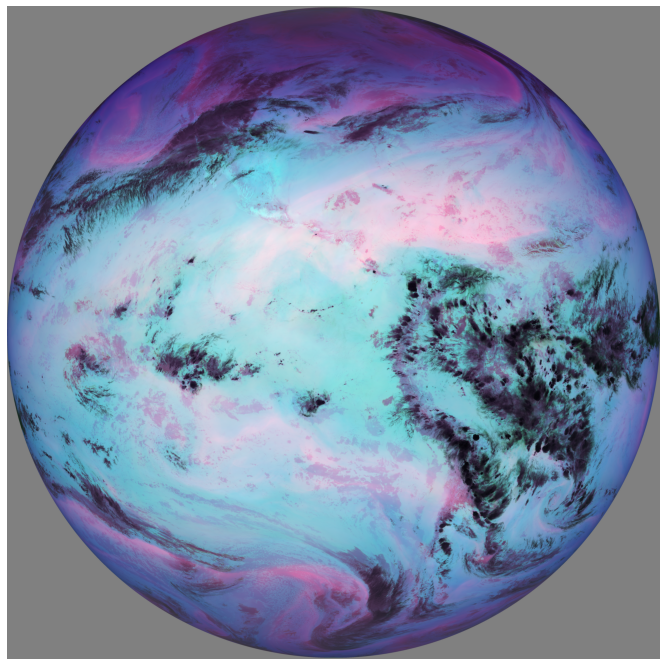

In [17]:

fig = plt.figure(figsize=(12, 12))
plt.imshow(combined)
plt.axis('off')


# Create a function that will generate these composite images for a given timestamp.

In [18]:
def generate_composite(dt=datetime(year=2017,month=6,day=1,hour=0),bands=[8,12,16],my_dpi=200,show=False,save_img=True):
    year=dt.year
    day_of_year=dt.timetuple().tm_yday
    hour=dt.hour
    r=gen_disk(year,day_of_year,hour,bands[0])
    g=gen_disk(year,day_of_year,hour,bands[1])
    b=gen_disk(year,day_of_year,hour,bands[2])
    combined=np.dstack([r,g,b])
    fig=plt.figure(figsize=(300/my_dpi, 300/my_dpi), dpi=my_dpi);
    plt.axis('off')
    plt.imshow(combined)
    if save_img:
        centered_filename=rf"./full_disks/fd{year}{day_of_year}{hour}.png"
        plt.savefig(centered_filename, bbox_inches='tight',pad_inches=0,transparent=True);
    if show:
        plt.show()
    plt.close(fig)

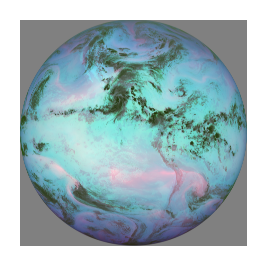

In [19]:
generate_composite(save_img=False,show=True)

# Load Track Data

In [20]:
filtered=pd.read_pickle('filtered.pkl')
for i in ['year','day_of_year','hour']:
    filtered[i]=filtered[i].astype(int)

In [21]:
len(filtered)

5519

# Sample Storm

In [22]:
row=filtered.iloc[1]
print(row)

SID                                        2017130N09269
ISO_TIME                             2017-05-09 21:00:00
LAT                                              9.40006
LON                                           -91.470001
STORM_SPEED                                          5.0
STORM_DIR                                           36.0
sin_STORM_DIR                                   0.587891
cos_STORM_DIR                                   0.809082
year                                                2017
day_of_year                                          129
sin_day_of_year                                 0.792477
cos_day_of_year                                -0.609902
hour                                                  21
sin_hour                                       -0.519584
cos_hour                                        0.854419
delta_lat_48hrs                                 2.534941
delta_lon_48hrs                                -2.692497
lagged_delta_lat               

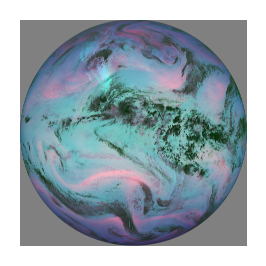

Wall time: 8.48 s


In [23]:
%%time
generate_composite(row['ISO_TIME'],show=True,save_img=False)

# Generate Our Images
I ended up generating these in batches, due to some errors I encountered along the way. I believe those issues have all been sorted out, but the code below is intended to pick up from an incomplete previous run. It looks for images already generated and then culls them from the list of new images to make.

Further, I make use of multiprocessing here. Note the function used here (generate_composite_mp) is located in an external file. It is identical to generate_composite() above, but multiprocessing will not work in some environments within a Jupyter notebook (particularly when using Windows) unless the function is located in an external file. See [here](https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac).

In [24]:
generated_files=pd.Series(os.listdir(r"./full_disks/"))
filtered['full_disk_file']="fd"+filtered['year'].astype('str')+filtered['day_of_year'].astype('str')+filtered['hour'].astype('str')+".png"
len(filtered)

5519

In [25]:
missing_images=filtered[~filtered['full_disk_file'].isin(generated_files)]
len(missing_images)

0

In [26]:
datetimes=missing_images[['ISO_TIME']].drop_duplicates().reset_index(drop=True)

In [27]:
# if __name__ ==  '__main__': #need this for the reduceLRonPlat to work correctly
#     pool=Pool(processes=8)
#     pool.map(generate_composite_mp,datetimes['ISO_TIME'])
#     pool.close()

In [28]:
filtered=filtered[filtered['full_disk_file'].isin(generated_files)].dropna()
len(filtered)

5519

# Check out some Samples

In [29]:
def get_image_from_row(row,COLOR_BGR2RGB=False):
    path=rf"./full_disks/fd{row['year']}{row['day_of_year']}{row['hour']}.png"
    image = cv2.imread(path)  
    if cv2.COLOR_BGR2RGB:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

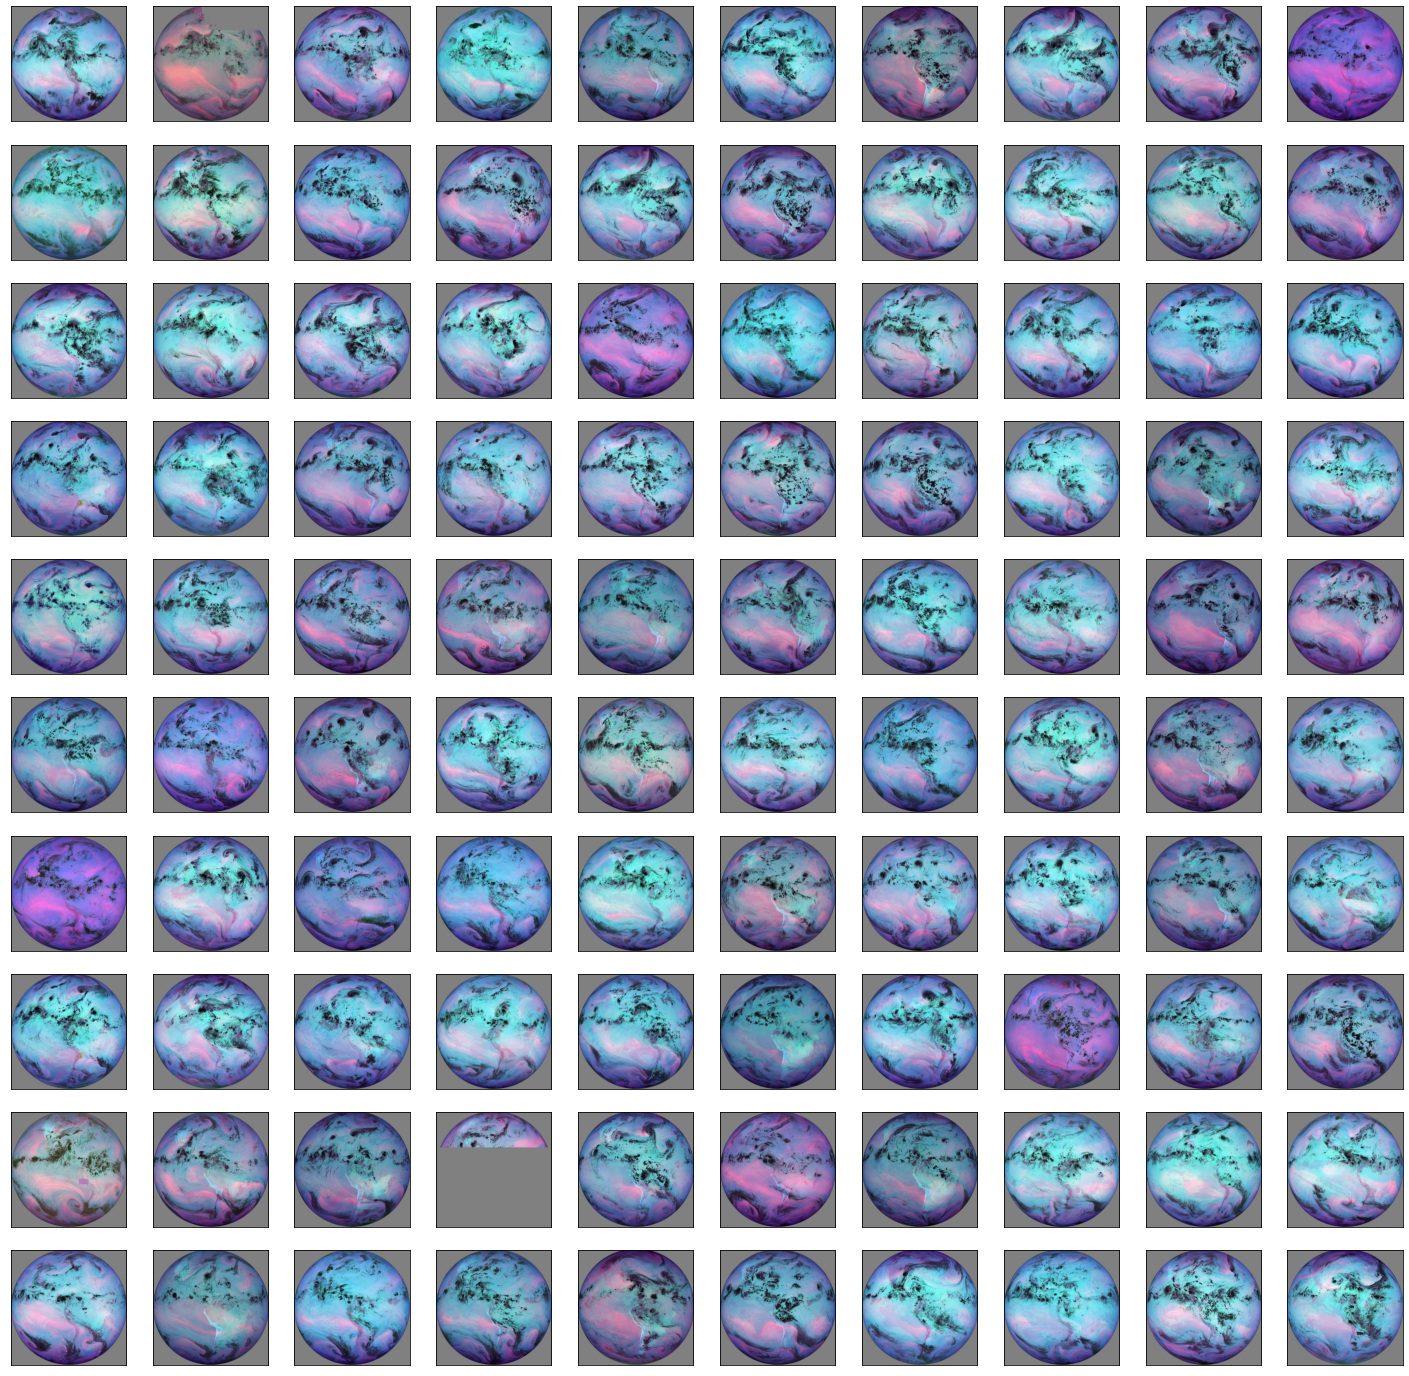

In [30]:
fig = plt.figure(figsize=(25, 25))
for i, (idx, row) in enumerate(filtered.sample(100, random_state=2021).iterrows()):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    image=get_image_from_row(row)
    plt.imshow(image)

These look pretty good. Let's incorporate them into the model.

# Model Design
## Baseline Model
Our first model will be our first best guess at a reasonable architecture based on best practices. It will simple, while making use of as much of the data we have available. 

We'll use a simple dense network for now to process the centered image data, though later, we'll want to try transfer learning with models like MobileNetm which is why we'll make this a separate tree from the 'deep' one. The output of this branch of the network will concatenate with a [wide and deep network](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html), which will process the tabular data. Continuous numerical data (which will feed into the "deep" part of the deep and wide architecture), will include the latitude and longitude of the storm where it is now, the sine of its heading (since 359 degrees is closer to 1 degree than it is 270 degree), and its speed. Discrete / onehot data (for the "wide part) will be provided via tensorflow feature columns, which will bucketize the latitude and longitude coordinates, then do a [feature cross](https://developers.google.com/machine-learning/crash-course/feature-crosses/crossing-one-hot-vectors) to create a onehot grid of locations, only one of which will be our storm's present location. Doing this outside of tensorflow can be quite tedious.

Here's a visual representation of a wide and deep network. Remember, we'll be bringing in a third branch for the image processing in addition to the 'wide' and 'deep' portions. We conceivably could just feed this into the 'deep' branch, but using it in its own branch will allow us more flexibility to test different architectures specifically designed to work with image data later.
![wide and deep](https://1.bp.blogspot.com/-Dw1mB9am1l8/V3MgtOzp3uI/AAAAAAAABGs/mP-3nZQCjWwdk6qCa5WraSpK8A7rSPj3ACLcB/s1600/image04.png)

To get started, we're going to have to build a Tensorflow dataset.

In [31]:
print(tf.__version__)

2.4.1


We'll be using data from the "filtered" dataframe, along with the images referenced by the rows of that dataframe. We'll also filter it to remove any null labels, after first adding in the new lagged variables for the previous lat / lon coordinate, which we haven't done yet. The following function should handle the preprocessing of that data for us and load the needed image data as well.

In [32]:
#I built this into the original notebook to avoid missing timesteps due to issues with available data

# SIDs=filtered['SID'].drop_duplicates()

# new=[]
# for SID in SIDs:
#     temp=filtered[filtered['SID']==SID].copy()
#     temp['lagged_lat']=temp['LAT'].shift(1)
#     temp['lagged_lon']=temp['LON'].shift(1)
#     new.append(temp)
# filtered=pd.concat(new,axis=0)
# filtered.head() 

In [33]:
filtered.columns

Index(['SID', 'ISO_TIME', 'LAT', 'LON', 'STORM_SPEED', 'STORM_DIR',
       'sin_STORM_DIR', 'cos_STORM_DIR', 'year', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'hour', 'sin_hour', 'cos_hour',
       'delta_lat_48hrs', 'delta_lon_48hrs', 'lagged_delta_lat',
       'lagged_delta_lon', 'filename', 'size', 'full_disk_file'],
      dtype='object')

Before we do our train / test split, we need to figure out which columns we wish to use. We already did some feature engineering when we imported the track data, such as taking the sine and cosine of several cyclical columns, like hour of day, storm heading, etc., so at this point, it's just planning next steps and selecting what we want.
1.  SID: this is only really useful if we hold off on forecasting a new storm until we have a few timesteps to incorporate into our training set and can retrain with them. For now, because of how we're doing the train / val / test split (i.e. by SID), I'm going to leave this out.
1.  Lat Lon: Latitude is not cyclical in the way longitude is, and given that we're not looking at the full globe, we can treat them essesntially just like X,Y coorindates. No need to use sines or cosines here. We'll use these directly to feed into the deep network branch, but also bucketize and feature cross them as described above to feed into the wide part. We'll likely want several thousand grid squares here (this is a hyperparameter we may wish to experiment with later), so we may want to also feed these gridpoints into embedding feature columns as well, depending on the number of grid squares we use.
1.  time: we'll discard raw time, as well as year. We don't want to overfit this and providing raw time is an easy way to do that. We do, however, want to learn seasonality and and sort of impacts time of day have. In both instances, we'll want to convert day of year and hour of day with a sine function since December 31st is close to January 1st and 11pm is close to 1am. We can bucketize both as well and feed the buckets to the wide part while feeding the continuous numerical sine values to the deep part.
1.  Storm speed: similar to above, we'll take the raw speed and bring it into the deep network and bucketize it to send to the wide part.
1.  Storm direction: we already preprocessed this by taking the sine of it when we originally imported the csv file, since it was an obvious step. When we define our feature columns, we'll be sure to also bucketizing it as well and treat it like our other variables.
1.  Image data: this is pretty standard and more or less all handled by tensorflow. We may wish to at some point consider some data augmentation, such as slightly rotating images, zooming, etc., but for now, we'll try it raw. I plan to also try this with a capsule network for the image branch, which would prefer the raw images to skewed or rotated ones.
1.  File size: We will have this for live predictions, and it may actually be useful. We'll include it both in its bucketized as well as raw format. This may capture some level of 'meta' data regarding the complexity of the weather patterns and local terrain, which could potentially have some predictive value.

Note: there are other variables that would be nice to include as well such as storm intensity or wind speed. However, this isn't available for all our datapoints in our current datasets. I have no doubt we can pull this in from alternative sources in a future model, along with other features, like pressure and temperature.

## Issue with Hours
Some quick exploration in Excel shows that a very small number of the 22994 original records in here are for times that fall outside the 0,3,6,9,12,15,18,21 hour timestamps. Therefore, I'm just going to filter those out so we don't need to worry about any more intricate time transformations later, and will have fewer buckets of daily time to handle in our model.

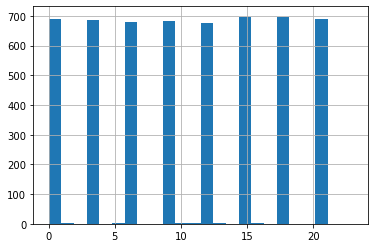

In [34]:
filtered['hour'].hist(bins=24)

In [35]:
regular_hours=[0,3,6,9,12,15,18,21]
filtered=filtered[filtered['hour'].isin(regular_hours)]
len(filtered)

5497

# Train / Val / Test Split
We also need to split our dataset into parts. With Time Series data, which this arguably is, there is some debate around the best way to do this. Essentially, common best practice is to keep the oldest data as the training set, the period directly after as validation (to tell when to stop training and prevent overfitting, mostly), and the most current is the test set. Once you have an architecture that works well, you do one last training run with all the data included so that your live forecasts are as solid as possible. 

In the case of our data, however, we have a cleaner way to do this. The reason for the above way of splitting data is mostly that time series data commonly contains 'lagged' variables... that is past historic track locations, or something to that effect. And if you just randomly sample from your entire pool of data to generate your validation or test sets, you model may already have gained sufficient insight into those datapoints from the adjacent ones due the presence of these lagged variables, and thus appear to work very well. Then, when you start using it on live data, it fails. This is because method led to overfitting.

In our case, however, I think we can get away with sampling by storm, since each storm track should be independent of other storm tracks (for the most part). There are instances where multiple storms will merge, like what happened with Superstorm Sandy, but those are edge cases and as long as our validation and test sets are sufficiently large, we should be ok even if they include one or two such storms.

Note: we will still likely want to re-train our final model with the full dataset before deploying for live forecasts, but only after we have a sense for number of training epochs and learning rates so we don't overfit, and the only way to do that adequately is with validation and test sets.

In [36]:
all_storms=filtered['SID'].drop_duplicates()
len(all_storms)

144

In [37]:
filtered.dtypes

SID                         string
ISO_TIME            datetime64[ns]
LAT                        float32
LON                        float32
STORM_SPEED                float32
STORM_DIR                  float32
sin_STORM_DIR              float32
cos_STORM_DIR              float32
year                         int32
day_of_year                  int32
sin_day_of_year            float32
cos_day_of_year            float32
hour                         int32
sin_hour                   float32
cos_hour                   float32
delta_lat_48hrs            float32
delta_lon_48hrs            float32
lagged_delta_lat           float32
lagged_delta_lon           float32
filename                    object
size                       float32
full_disk_file              object
dtype: object

In [38]:
filtered.columns

Index(['SID', 'ISO_TIME', 'LAT', 'LON', 'STORM_SPEED', 'STORM_DIR',
       'sin_STORM_DIR', 'cos_STORM_DIR', 'year', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'hour', 'sin_hour', 'cos_hour',
       'delta_lat_48hrs', 'delta_lon_48hrs', 'lagged_delta_lat',
       'lagged_delta_lon', 'filename', 'size', 'full_disk_file'],
      dtype='object')

In [39]:
float_cols=['LAT', 'LON', 'STORM_SPEED', 'STORM_DIR',
       'sin_STORM_DIR', 'cos_STORM_DIR', 'year', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'hour', 'sin_hour', 'cos_hour',
       'delta_lat_48hrs', 'delta_lon_48hrs','size']
for col in float_cols:
    filtered[col]=filtered[col].astype('float32')

In [40]:
# filtered.to_pickle('filtered.pkl')
train_df=pd.read_pickle('train_df.pkl')
val_df=pd.read_pickle('val_df.pkl')
test_df=pd.read_pickle('test_df.pkl')

In [41]:
train_df=filtered[filtered['SID'].isin(train_df['SID'])]
val_df=filtered[filtered['SID'].isin(val_df['SID'])]
test_df=filtered[filtered['SID'].isin(test_df['SID'])]

## Save DataFrames
We'll pick up from here in subsequent notebooks.

# Create Tensorflow Dataset
Tensorflow has made some major changes in recent years, especially with V2.0. TF.Data is among the biggest. Instead of training with basic numpy arrays as inputs, Tensorflow would now like you to use its own data format. You still can use numpy if your dataset fits in memory, or even use a generator to create samples if it does not, but you're only using a single local machine. However, if you want to train with tf.estimator, which lets you easily train across a cluster in the cloud or across multiple gpus on a single machine, you need to use tf.data. Further, using tf.data allows us to use Tensorflow's 'feature columns' which, as previously discussed, we'll be using here. They allow you to do a fair amount of both preprocessing, like normalization, without needing to use SK-Learn, but more relevant to this project, they enable us to created bucketized features and feature crosses with just a few lines of code.

That all said, the Tensorflow Dataset can be a bit tricky to setup, especially with a multi-input model like we'll be using here. Further, the examples given in the tensorflow documentation assume that our dataset consists of all files within a given directory. But we have plenty of images we don't wish to use, and we also need to ensure consistency between the images we load, and the associated other data we wish to train with. So, using tf.keras.preprocessing.image_dataset_from_directory is out of the question for us. We'll need to instead write our own preprocessing functions, and then map everything to a single dataset.

Much of this code follows the example from the Tensorflow documentation on [using tf.data for finer control](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control).

In [42]:
centered_filenames=r"./storm_centered/"+filtered['filename']
print(centered_filenames.head())

1     ./storm_centered/centered_2017106N36310_201710...
42    ./storm_centered/centered_2017130N09269_201712...
43    ./storm_centered/centered_2017130N09269_201713...
44    ./storm_centered/centered_2017130N09269_201713...
45    ./storm_centered/centered_2017130N09269_201713...
Name: filename, dtype: object


In [43]:
centered_files_ds=tf.data.Dataset.from_tensor_slices(centered_filenames)
list(centered_files_ds.take(1))

[<tf.Tensor: shape=(), dtype=string, numpy=b'./storm_centered/centered_2017106N36310_20171069.png'>]

In [44]:
experimental=dict(filtered)

In [45]:
img_height=img_width=224
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
    img= tf.image.resize(img, [img_height, img_width])
    return preprocess_input(img)

In [46]:
def process_path(file_path,return_dict=True):
#     label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    if return_dict:
        return {'image':img}
    else:
        return img

In [47]:
def load_all_images(paths):
    imgs=[]
    for path in paths:
        imgs.append(process_path(path,return_dict=False))
    return imgs

In [48]:
img_paths=r"./storm_centered/"+test_df['filename']

images=load_all_images(img_paths)

In [49]:
print(images[0].shape)

(224, 224, 3)


## Two Versions of "create_dataset" function
If we scale this up, we're going to want a dataset that can pull batches off of some sort of storage medium, either locally or on the cloud. However, this entire dataset of both images and auxillary numerical data should easily fit in memory on my system, which has 64GB of RAM. Caching a dataset to memory is significantly faster and less CPU intense, as it doesn't require multiple threads to work in tandum preparing the next batch while one is being used. Normally, we'd just use the tf.data dataset's "cache" method to load it to memory during the first epoch of training, but it turns out that in the case of tf.data, it's also much easier to format it correctly if we load all the image data within the create_dataset function, since we can add both our numerical and image data to a single Python dictionary, and then create a dataset from tensor slices in a single call. Zipping image data to auxillary data via the other approach is tricky, as the image data gets nested within the auxillary dataset, and I'm not certain yet that the model's feature columns will work properly with it via a simple reference to the "image" feature.

For now, I'm going to use the approach below in the "create_dataset" function which loads all image data at time of creation and caches the dataset to memory.

I'm also including an as of yet untested version called "create_dataset_not_cached" which loads image data on the fly, but might not work properly with the model we build later, since I'm not sure if we can simply link the image features to our model.

In [50]:
def create_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    centered_img_paths=r"./storm_centered/"+dataframe.pop('filename')
    full_disks=r"./full_disks/"+dataframe.pop('full_disk_file')
#     all_images=load_all_images(img_paths)
    labels = dataframe[['delta_lat_48hrs', 'delta_lon_48hrs']].copy()
    dataframe.drop(columns=['SID','ISO_TIME','year','day_of_year', 'delta_lat_48hrs','delta_lon_48hrs'],inplace=True)
    inputs=dict(dataframe)
    inputs['centered_image']=load_all_images(centered_img_paths)
    inputs['full_disk']=load_all_images(full_disks)    
    ds=tf.data.Dataset.from_tensor_slices((inputs,labels.values))
#     dataset = tf.data.Dataset.from_tensor_slices(({"input_1": sent1, "input_2": sent2}, labels))


#     labels_ds=tf.data.Dataset.from_tensor_slices(labels.values)
#     ds = tf.data.Dataset.from_tensor_slices((all_input_ds, dict(labels)))
#     ds = tf.data.Dataset.zip((all_input_ds, labels_ds))
    ds=ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    
    return ds

In [51]:
batch_size=32

#we want to load our data to system memory, not our GPU's memory. That will be reserved for our model.
with tf.device('/CPU:0'):
    train_ds=create_dataset(train_df,batch_size=batch_size)
    val_ds = create_dataset(val_df,batch_size=batch_size,shuffle=False)
    test_ds=create_dataset(test_df,batch_size=batch_size,shuffle=False)

In [52]:
list(train_ds.take(1))

[({'LAT': <tf.Tensor: shape=(32,), dtype=float32, numpy=
   array([23.1667, 17.4574, 19.6   , 17.6   , 14.2724,  9.5   , 15.9   ,
          16.7   , 18.1   , 25.9   , 11.9998, 29.6   , 13.4   , 14.2573,
          13.3499, 17.0848, 14.5401, 22.3878, 12.0148, 14.4311, 12.6998,
          25.    , 16.7   , 13.9924, 31.3574, 20.2   , 20.3   , 33.3   ,
          14.2   , 18.3   , 26.6875, 10.1625], dtype=float32)>,
   'LON': <tf.Tensor: shape=(32,), dtype=float32, numpy=
   array([ -90.1667, -113.858 , -118.4   ,  -42.4   , -120.435 , -102.2   ,
          -111.7   ,  -78.4   ,  -70.5   ,  -51.1   , -136.843 ,  -56.8   ,
           -33.    ,  -47.4927, -124.292 , -118.442 , -119.025 ,  -95.4504,
          -126.735 , -102.997 , -140.958 ,  -66.9   ,  -39.5   , -138.322 ,
           -72.3726,  -72.4   ,  -59.4   ,  -83.3   , -106.4   ,  -33.5   ,
           -66.9775, -126.773 ], dtype=float32)>,
   'STORM_SPEED': <tf.Tensor: shape=(32,), dtype=float32, numpy=
   array([ 8.,  9.,  6.,  3., 10., 

# Create Feature Columns
Creating a tf.data dataset like we did above is clearly more complicated than what most of us Tensorflow Developers have historically done when training with simple numpy data. But here's the payoff; we'll be doing some really fancy data engineering right within our model using Tensorflow's new feature_column class, which will enable us to handle non-linearities and interaction between dependent features (like latitude and longitude) much better than we otherwise could, without heavy preprocessing. We can also do the more standard preprocessing steps, like normalization, much more easily and without the need to fit a SK-Learn scaler object separately.

## Bring in Data
In our current dataset, the only categorical is hour of day. Recall, we also use two engineered continuous numerical equiavalents for this as well, but the raw categorical may end up being useful.  We removed year and day_of_year in favor of our numerical equivalents, as those could lead to overfitting.

## Normalization
Reference: https://medium.com/ml-book/train-tf-keras-model-using-feature-coulmn-8de12e65ddec

In [53]:
def get_scal(feature):
    def minmax(x):
        mini = train_df[feature].min()
        maxi = train_df[feature].max()
        return (x - mini)/(maxi-mini)
    return(minmax)

In [54]:
numeric_names=['LAT', 'LON', 'STORM_SPEED', 'STORM_DIR',
       'sin_STORM_DIR', 'cos_STORM_DIR','sin_day_of_year', 
       'cos_day_of_year', 'sin_hour', 'cos_hour','size']

categorical_names=['hour']


deep_features=[]
for name in numeric_names:
    scal_input_fn = get_scal(name)
    deep_features.append(fc.numeric_column(name,normalizer_fn=scal_input_fn))

#we only have one of these... hour
wide_features=[fc.indicator_column(fc.categorical_column_with_vocabulary_list('hour',vocabulary_list=regular_hours))]

centered_image_features=fc.numeric_column('centered_image',shape=(img_height,img_width,3))
full_disk_image_features=fc.numeric_column('full_disk',shape=(img_height,img_width,3))


# Feature Engineering with feature_columns
Reference: https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

### Position Encoding

In [15]:
num_coordinate_buckets=50 #this is a variable we'll want to experiement with eventually
num_lag_buckets=15
latitude_buckets = list(np.linspace(filtered['LAT'].min(), filtered['LAT'].max(), num_coordinate_buckets))
longitude_buckets = list(np.linspace(filtered['LON'].min(), filtered['LON'].max(), num_coordinate_buckets))
lagged_lat_buckets = list(np.linspace(filtered['lagged_delta_lat'].min(), filtered['lagged_delta_lat'].max(), num_lag_buckets))
lagged_lon_buckets = list(np.linspace(filtered['lagged_delta_lon'].min(), filtered['lagged_delta_lon'].max(), num_lag_buckets))


latitude_fc = tf.feature_column.bucketized_column(deep_features[0],latitude_buckets)
longitude_fc = tf.feature_column.bucketized_column(deep_features[1],longitude_buckets)

lagged_lat_fc = tf.feature_column.bucketized_column(deep_features[11],lagged_lat_buckets)
lagged_lon_fc = tf.feature_column.bucketized_column(deep_features[12],lagged_lon_buckets)

# cross features for grid boxes locations.
crossed_loc = fc.crossed_column(
    [latitude_fc, longitude_fc],
    hash_bucket_size=num_coordinate_buckets * num_coordinate_buckets)

crossed_lagged_loc = fc.crossed_column(
    [lagged_lat_fc, lagged_lon_fc],
    hash_bucket_size=num_lag_buckets * num_lag_buckets)

wide_features.append(fc.indicator_column(crossed_loc))
wide_features.append(fc.indicator_column(crossed_lagged_loc))

# wide_features=tf.feature_column.make_parse_example_spec(wide_features)

# add embedding layer output of this we can also feed into deep network
loc_embedding = fc.embedding_column(categorical_column=crossed_loc, dimension=8)
lagged_loc_embedding = fc.embedding_column(categorical_column=crossed_lagged_loc, dimension=8)
deep_features.append(loc_embedding)
deep_features.append(lagged_loc_embedding)

# deep_features=tf.feature_column.make_parse_example_spec(deep_features)


### Bucketization of Other Variables
Storm speed, Storm direction, and file size.

In [56]:
general_buckets=20
speed_buckets = list(np.linspace(filtered['STORM_SPEED'].min(), filtered['STORM_SPEED'].max(), general_buckets))
dir_buckets = list(np.linspace(filtered['STORM_DIR'].min(), filtered['STORM_DIR'].max(), general_buckets))
size_buckets = list(np.linspace(filtered['size'].min(), filtered['size'].max(), general_buckets))


speed_fc = tf.feature_column.bucketized_column(deep_features[2],speed_buckets)
dir_fc = tf.feature_column.bucketized_column(deep_features[3],dir_buckets)
size_fc = tf.feature_column.bucketized_column(deep_features[10],size_buckets)

wide_features.append(fc.indicator_column(speed_fc))
wide_features.append(fc.indicator_column(dir_fc))
wide_features.append(fc.indicator_column(size_fc))

# Build Super Simple Model

In [57]:
INPUT_COLS = ['LAT', 'LON', 'STORM_SPEED', 'STORM_DIR','sin_STORM_DIR', 'cos_STORM_DIR',
       'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour', 'size']

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS}
inputs['hour']= Input(name='hour', shape=(), dtype='int32')

inputs['centered_image']=Input(name='centered_image',shape=(img_height,img_width,3),dtype='float32')
inputs['full_disk']=Input(name='full_disk',shape=(img_height,img_width,3),dtype='float32')

In [58]:
inputs['hour']

<KerasTensor: shape=(None,) dtype=int32 (created by layer 'hour')>

## Loss

In [59]:
def build_model(dnn_hidden_units=[32],out_dim=2):
    
    # Create the deep part of model
    deep = DenseFeatures(deep_features, name='deep_inputs')(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation='relu')(deep) 

    # Create the wide part of model
    wide = DenseFeatures(wide_features, name='wide_inputs')(inputs)


    centered_image_net=Conv2D(32, (3, 3), activation='relu')(inputs['centered_image'])
    centered_image_net=MaxPooling2D((2, 2))(centered_image_net)
    centered_image_net=Conv2D(64, (3, 3), activation='relu')(centered_image_net)
    centered_image_net=MaxPooling2D((2, 2))(centered_image_net)
    centered_image_net=Conv2D(64, (3, 3), activation='relu')(centered_image_net)
    centered_image_net=Flatten()(centered_image_net)
    centered_image_net=Dense(16,activation='relu')(centered_image_net)

    fd_image_net=Conv2D(32, (3, 3), activation='relu')(inputs['full_disk'])
    fd_image_net=MaxPooling2D((2, 2))(fd_image_net)
    fd_image_net=Conv2D(64, (3, 3), activation='relu')(fd_image_net)
    fd_image_net=MaxPooling2D((2, 2))(fd_image_net)
    fd_image_net=Conv2D(64, (3, 3), activation='relu')(fd_image_net)
    fd_image_net=Flatten()(fd_image_net)
    fd_image_net=Dense(16,activation='relu')(fd_image_net)
    
    
    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide,centered_image_net,fd_image_net], name='combined')
    batch_norm_layer=BatchNormalization()(combined)
    final_wide_layer=Dense(16,activation='relu')(batch_norm_layer)

    dropout_layer=Dropout(0.3)(final_wide_layer)
    # Map the combined outputs into a single prediction value
    output = Dense(out_dim, activation=None, name='prediction')(dropout_layer)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)

    # Compile the keras model
    model.compile(loss=mean_pairwise_squared_error, optimizer=Adamax(lr=1e-3,clipnorm=1.))
    
    return model

In [60]:
model=build_model()

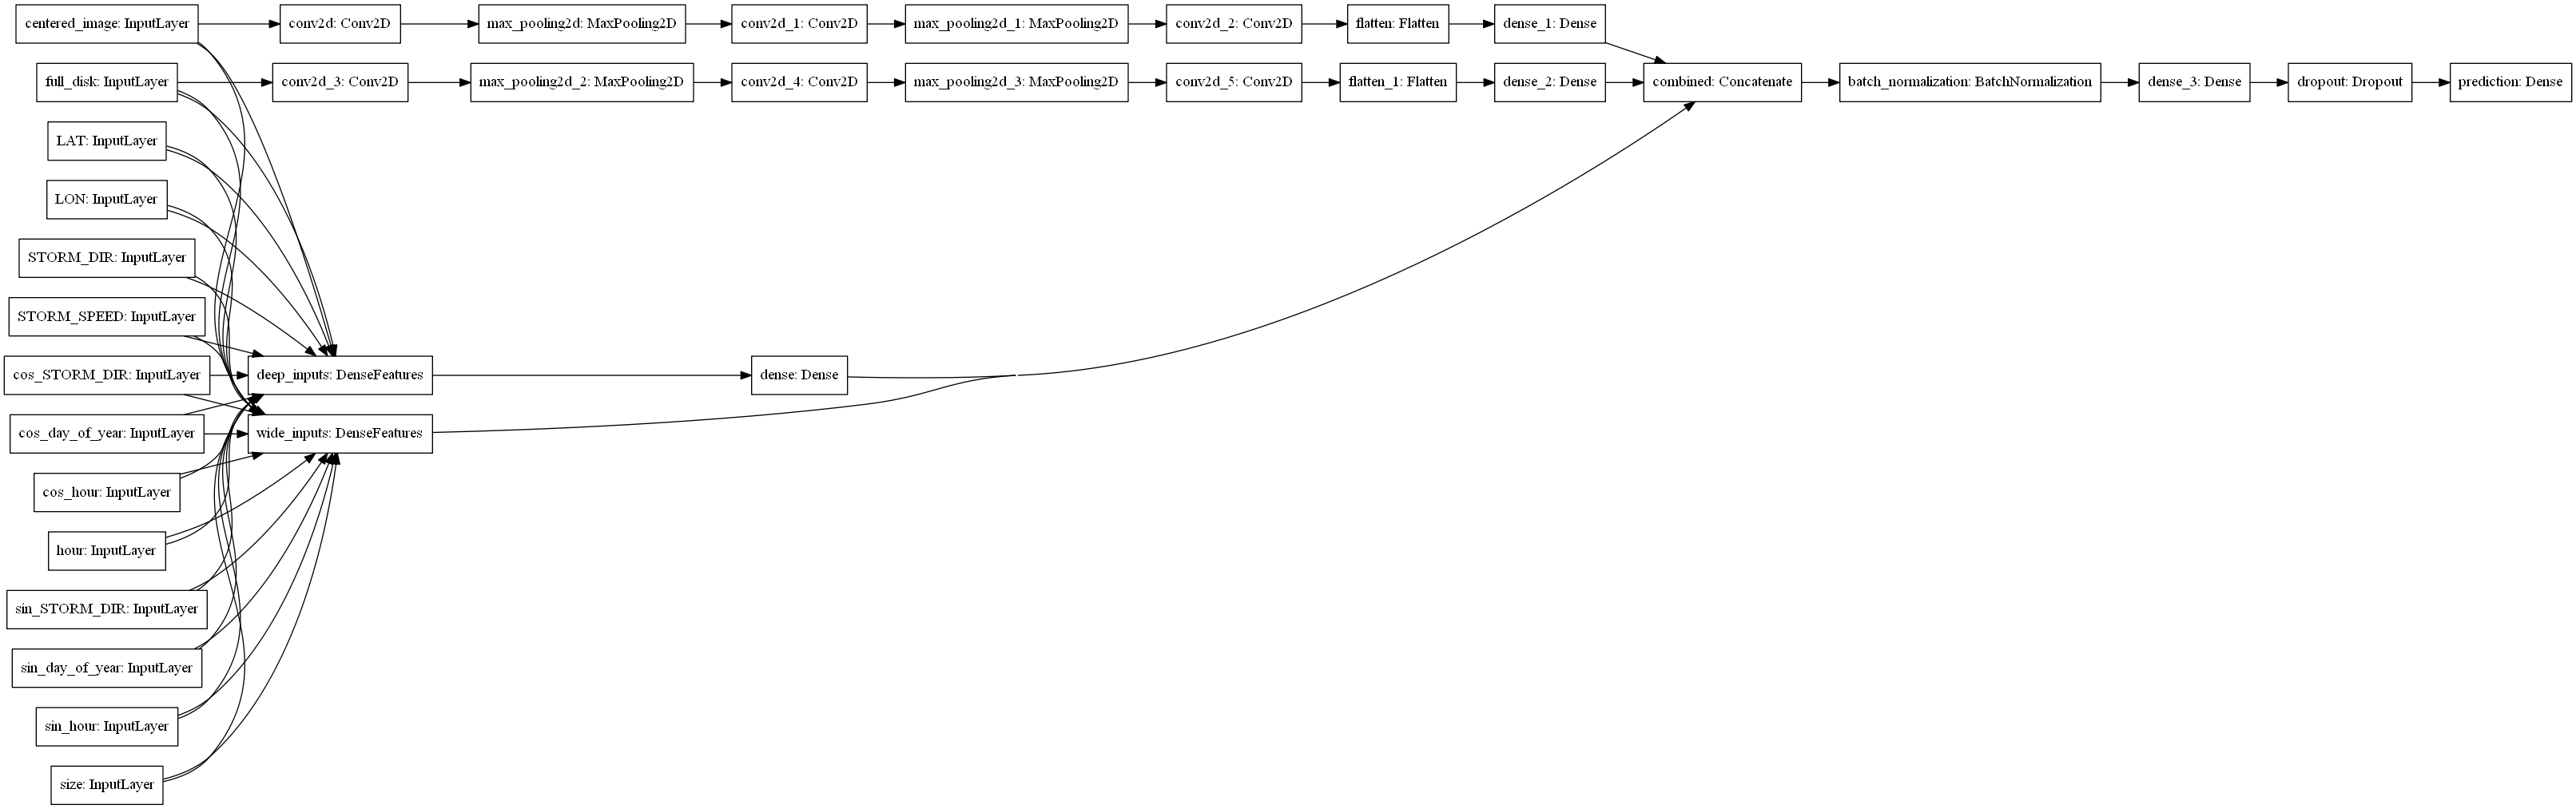

In [61]:
tf.keras.utils.plot_model(model, 'full_disk_model.png', show_shapes=False, rankdir='LR')


# Callbacks

In [62]:
reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, cooldown=0, 
                                   verbose=1, mode='auto', min_delta=1e-8, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

callback_list=[reduceLROnPlat,early]

Note: changed reduceLROnPlateau to use val_loss as indicator and limited min LR based on previous run. Training loss fluctuated a lot due to the dropout layers.

# Train Model

In [ ]:
if __name__ ==  '__main__': #need this for the reduceLRonPlat to work correctly
    history = model.fit(train_ds,validation_data=val_ds,batch_size=batch_size,epochs=100,callbacks=callback_list)

Epoch 1/100


C:\Users\kylea\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:592: UserWarning: Input dict contained keys ['lagged_delta_lat', 'lagged_delta_lon'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


150/150 [==============================] - 29s 160ms/step - loss: 2282.3802 - val_loss: 2932.7092
Epoch 2/100
150/150 [==============================] - 21s 140ms/step - loss: 911.3689 - val_loss: 3240.3284
Epoch 3/100
150/150 [==============================] - 20s 136ms/step - loss: 618.0166 - val_loss: 2373.5071
Epoch 4/100
150/150 [==============================] - 22s 149ms/step - loss: 497.7056 - val_loss: 2269.6667
Epoch 5/100
150/150 [==============================] - 20s 133ms/step - loss: 421.3174 - val_loss: 2157.9563
Epoch 6/100
150/150 [==============================] - 22s 149ms/step - loss: 399.1335 - val_loss: 2396.9873
Epoch 7/100
150/150 [==============================] - 20s 133ms/step - loss: 351.5436 - val_loss: 2158.7766
Epoch 8/100
150/150 [==============================] - 23s 152ms/step - loss: 344.5754 - val_loss: 1964.4365
Epoch 9/100
150/150 [==============================] - 21s 143ms/step - loss: 356.1616 - val_loss: 1849.4421
Epoch 10/100
150/150 [========

In [ ]:
history_df=pd.DataFrame(history.history)

In [ ]:
history_df.head()

In [ ]:
history_df[['loss','val_loss']].plot()

In [ ]:
model.save('full_disk_model.h5')

# Evaluate Model
The curve above shows this model starts overfitting pretty quickly. We do use the model when it had the lower validation error thanks to our use of callbacks here, but the overfitting indicates this model could benefit from more training data. The use of reanalysis data may get us what we need. We could also try some data augmentation, especially with the image data, as well as add dropout layers, and incorporate some regularization.

Validition error is useful at an intellectual level, but what does it really mean? Let's plot a couple sample tracks and compare with what really happened to see how well this performs.

In [ ]:
predictions=model.predict(test_ds)

In [ ]:
# pred_cols=["pred_"+x for x in ['delta_lat_m3', 'delta_lon_m3', 'delta_lat_m6', 'delta_lon_m6',
#        'delta_lat_m9', 'delta_lon_m9', 'delta_lat_m12', 'delta_lon_m12']]
pred_cols=["pred_lat","pred_lon"]

predictions_df=pd.DataFrame(predictions,columns=pred_cols,index=test_df.index)
predictions_df.head()

In [ ]:
predictions_df=predictions_df.merge(test_df,left_index=True,right_index=True)
predictions_df.head()

In [ ]:
predictions_df.to_pickle('fd_predictions.pkl')

if resuming from a previous run, load previous predictions...

In [ ]:
predictions_df=pd.read_pickle('fd_predictions.pkl')

In [ ]:
SID='2020254N11343'# use this to ensure consistent example across runs.
#predictions_df['SID'].sample(1,random_state=2021).values[0]
sample_storm=predictions_df[predictions_df['SID']==SID].copy()
lllon=sample_storm['LON'].min()-10
urlon=sample_storm['LON'].max()+10
center=(lllon+urlon)/2
lllat=sample_storm['LAT'].min()-10
urlat=sample_storm['LAT'].max()+10
sample_storm.head(5)

To compare Apples to Apples, we need to plot our forecasts from a given point at each of the timesteps out (which will all be on one row) against actual future points (which will be on the following rows). So, we need to narrow our window for our storm track to 12 hours. Every 3 hours, we get a new projected trajectory. This might be tricky. Simplest solution is to build a function that will return what we want.

In [ ]:
def get_forecast_coords(row):
#     DT=row['ISO_TIME'].sample(1).values[0]

#     forecasts=predictions_df[(predictions_df['SID']==SID) & (predictions_df['ISO_TIME']==DT)]
    LATs=[row['LAT'],row['LAT']+row['pred_lat']]
    LONs=[row['LON'],row['LON']+row['pred_lon']]
    return LONs,LATs


In [ ]:
fig = plt.figure(figsize=(6,6),dpi=200)
m = Basemap(projection='geos', lon_0=center,lat_0=0,rsphere=(6378137.00,6356752.3142))
#             llcrnrx=X.min(), llcrnry=Y.min(), urcrnrx=X.max(), urcrnry=Y.max())
m.bluemarble(zorder=0)
m.plot(sample_storm['LON'].values,sample_storm['LAT'].values,latlon=True,color='r',zorder=10)
for i,row in sample_storm.iterrows():
    LONs,LATs=get_forecast_coords(row)
    m.plot(LONs,LATs,latlon=True,color='g',zorder=10)

# xmin, ymin = m(lllon, lllat)
# xmax, ymax = m(urlon, urlat)

# ax = plt.gca()

# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])


plt.show()

These results not too bad for a crude model such as this. But we can likely do much better. In the next notebook, we'll replace the dense network used to process the satellite images with MobileNetV2, so we can use transfer learning to increase accuracy. There are also a lot of hyperparameters here, such as neurons per layer, number of buckets to use for our variables, and other model changes we can make, such as our loss function. Instead of mean squared error, we could use a custom loss function that gives us approximate great circle distance between pairs of latitude and longitude, for instance.

# Design Improvements / Next Steps
1. Explore different RNN approaches, especially GRU and LSTM.
1. Explore using the new Tensorflow3D platform to model hurricanes using realtime 3d model data, like what's provided in the reanalysis data, and realtime forecast models.
1. Explore different CNN architectures. MobileNet is one of many.
1. Explore using full disk images both instead of and an addition to the centered views.
1. Bring in GOES17 data and test using it in two ways:
    1. To broaden the area where we can pull historic data from
    2. To narrow the area, but give us two views (stereoscopic) of each storm snapshot.
1. Test capsule networks both with the centered storm views and full disk views. Capsule networks are supposed to capture more information regarding where in an image a specific feature is located, which should make them more suited to this task than a network architecture design for type classification, which would be preferable if we were trting to look at images of storms and classify their severity, for instance.
1. Test using surface temperate and ground temperature data, which is available from GOES16 and 17, but for a much smaller timeframe. Augment with historic reanlysis data.
1. Test different output types. Make this into a classification problem where we identify which future gridpoint the storm will be located in, instead of its exact center.